# Project2
Новак Евгений <br>
Орлов Григорий <br>
Тожимухаммедов Асадбек <br>
Вариант: 1

----

## Условие: <br>
* **Реализовать метод наискорейшего спуска (золотое сечение), метод Левенберга-Марквартда**<br>

* **Тестовые функции**

1. Расчет минимума сильно-выпуклой функции:
		$$
		f(x) = \frac{L - \mu}{8} \left[ x_1^2 + \sum_{i=2}^n (x_i - x_{i+1})^2 - 2x_1 \right] + \frac{\mu}{2} \| x \|_2^2
		$$
		Полагаем $ L = 100, \mu = 0.1 $.

2. Расчет двойственной задачи к задаче расчета матрицы корреспонденций:
		$$
		f(x, y) = -(L, x) - (W, y) + \ln \left[ \sum_{i,j} \exp(-\alpha c_{ij} + x_i + y_j) \right]
		$$  
		Здесь: $ x \in R^n, \, y \in R^n, \, L, W \in R_{+}^n, \, \| L \|_1 = 1, \, \| W \|_1 = 1, \, \alpha \geq 1, \, c_{ij} \in [0, 1] $. Параметры $ L, W, c $ задаются случайно, $ \alpha = 100 $.

3. Функция Розенброка ($ x \in R^n, \, x^* \equiv 1_n, \, f^* = 0 $):  
		$$
		f(x) = (x_1 - 1)^2 + \alpha \sum_{i=2}^n (x_i - x_{i-1}^2)^2.
		$$  
		Параметр $ \alpha $ можно варьировать. Для тестов возьмем его 10.

4. Задача энтропийно-линейного программирования без ограничений:
		$$
		f(x) = \sum_{i=1}^n x_i \ln \frac{x_i}{\xi_i}, \, x \in R_{+}^n; \, (n = 10, \ldots 1000); \, \xi_i = 1/i
		$$

5. Линейная регрессия:
		$$
		f(x) = \sum_{i=1}^m ((a^i, x) - b_i)^2
		$$  
		Параметр $ m = 100, \, $ значения $ a^i \in R^n, \, b_i $ выбираются случайно.

6. Функция правдоподобия:
		$$
		f(x,y) = -\sum_{i=1}^{k}(x^T a^i + y) + \sum_{i=1}^{m}\ln(1 + \exp(x^T a^i + y))
		$$

* **Комментарии**

1. Начальная точка выбирается случайно на достаточно большом удалении от оптимальной точки. Расстояние фиксируется одним и тем же для разных размерностей задачи.  
2. Точность решения варьируется от $10^{-4}$ до $10^{-5}$ с шагом $10^{-5}$.  
3. Точность одномерного поиска варьируется от $10^{-7}$ до $10^{-8}$ с шагом $10^{-8}$.  
4. Размерность задачи варьируется: 10, 20, 30, 40, 50, 60, 60, 70, 80, 90, 100, 200, 400, 600, 800, 1000.  

* **Графики**

1. Для фиксированных выбранных значений точности одномерного поиска и точности решения задачи по функции построить график зависимости времени решения от размерности задачи.  
2. Для фиксированных выбранных значений размерности задачи и точности одномерного поиска построить график зависимости времени решения задачи от требуемой точности решения задачи по функции.  
3. Для фиксированных выбранных значений размерности и точности решения задачи по функции построить график зависимости времени решения от точности одномерного поиска.  
4. Для фиксированных выбранных значений точности одномерного поиска, размерности задачи и точности решения задачи по функции построить график зависимости времени решения от расстояния между начальной точкой и оптимальной точкой.  

In [1]:
import matplotlib.pyplot as plt
import autograd.numpy as agnp
import numpy as np
import autograd as ag
import copy
from typing import Callable
from typing import Dict, Any, Tuple
import time
import math

In [2]:
# Метод золотого сечения из прошлого проекта


def golden_section_search(
    f: Callable[[float, agnp.ndarray], float], a: float, b: float, d: agnp.ndarray, eps: float
) -> tuple[float, list, list, int]:
    phi = (1 + np.sqrt(5)) / 2
    x1 = a + (b - a) / (phi + 1)
    x2 = b - (b - a) / (phi + 1)
    f1, f2 = f(x1, d), f(x2, d)

    iter_num, lst_x, lst_y = 0, [], []
    lst_x.append(0)
    lst_y.append((a + b) / 2)

    while abs(b - a) > eps:
        iter_num += 1
        if f1 < f2:
            b = x2
            x2, f2 = x1, f1
            x1 = a + (b - a) / (phi + 1)
            f1 = f(x1, d)
        else:
            a = x1
            x1, f1 = x2, f2
            x2 = b - (b - a) / (phi + 1)
            f2 = f(x2, d)

        lst_x.append(iter_num)
        lst_y.append((a + b) / 2)
    return ((a + b) / 2, copy.deepcopy(lst_x), copy.deepcopy(lst_y), iter_num)

In [ ]:
eps_fastest = 10 ** (-4)
eps_golden = 10 ** (-7)


def the_fastest_descent(
    f: Callable[[agnp.ndarray, Dict[str, Any]], float],
    param_list: Dict[str, Any],
    x0: agnp.ndarray,
    max_steps: int,
    eps: float,
) -> Tuple[agnp.ndarray, ...]:
    x_old = agnp.copy(x0)

    def func_of_h(h: float, d: agnp.ndarray) -> float:
        return f(x_old + h * d, param_list)

    def localize_minimum(
        func_of_h: Callable[[float, agnp.ndarray], float], d: agnp.ndarray, h=10 ** (-2), max_iter=100, growth_factor=10
    ):

        a = 0
        b = a + h
        f_a = func_of_h(a, d)
        f_b = func_of_h(b, d)

        if f_b > f_a:
            # Ищем влево
            a, b = a - h, a
            f_a, f_b = func_of_h(a, d), func_of_h(b, d)
            while f_a < f_b and max_iter > 0:
                h *= growth_factor
                b = a
                a = a - h
                f_b = f_a
                f_a = func_of_h(a, f)
                max_iter -= 1
        else:
            # Ищем вправо
            while f_b < f_a and max_iter > 0:
                h *= growth_factor
                a = b
                b = a + h
                f_a = f_b
                f_b = func_of_h(b, d)
                max_iter -= 1

        return min(a, b), max(a, b)

    x_new = x_old
    d = -ag.grad(f, argnum=0)(x_old, param_list)  # -numerical_gradient(f, x0)
    while agnp.linalg.norm(d) ** 2 > eps and max_steps > 0:
        max_steps -= 1

        a, b = localize_minimum(func_of_h, d)
        x_new = x_old + (golden_section_search(func_of_h, a, b, d, eps_golden)[0]) * d
        d = -ag.grad(f, argnum=0)(x_new, param_list)
        x_old = agnp.copy(x_new)

    return x_new


def quadratic1d(x: agnp.ndarray, param_list: Dict[str, Any]) -> float:
    return x[0] ** 2 + x[1] ** 2 + x[2] ** 2


param_list, x0, max_steps, eps = {}, agnp.array([1.0, 0.9, -1]), 100, 1e-6
result = the_fastest_descent(quadratic1d, param_list, x0, max_steps, eps)
print("Quadratic1d:", result)  # Ожидается ~[(0, 0, 0)]

Quadratic1d: [-3.03108105e-08 -2.72797295e-08  3.03108105e-08]


In [4]:
# levenberg_markvatd


def hessian(func, x: np.ndarray):
    return ag.jacobian(ag.grad(func))(x)


def levenberg_markvatd2(
    f: Callable[[agnp.ndarray, Dict[str, Any]], float],
    param_list: Dict[str, Any],
    x0: agnp.ndarray,
    max_steps: int,
    eps: float,
) -> Tuple[agnp.ndarray, ...]:
    alpha = 10**4
    x_old = agnp.copy(x0)
    x_len = len(x_old)

    for _ in range(max_steps):
        grad_f = ag.grad(f, argnum=0)(x_old, param_list)
        if agnp.linalg.norm(grad_f) < eps:
            return x_old

        H = hessian(lambda args: f(args, param_list), x_old)

        while True:
            sk = agnp.linalg.inv(H + alpha * agnp.eye(x_len)) @ grad_f
            x_new = agnp.copy(x_old - sk)
            if f(x_new, param_list) < f(x_old, param_list):
                alpha /= 2
                break
            else:
                alpha *= 2

        x_old = agnp.copy(x_new)

    return x_new


def quadratic1d(x: agnp.ndarray, param_list: Dict[str, Any]) -> float:
    return x[0] ** 2 + x[1] ** 2 + x[2] ** 2


param_list, x0, max_steps, eps = {}, agnp.array([1.0, 0.9, -1]), 100, 1e-6
result = levenberg_markvatd2(quadratic1d, param_list, x0, max_steps, eps)
print("Quadratic1d:", result)  # Ожидается ~[(0, 0, 0)]

Quadratic1d: [ 1.51877547e-07  1.36689792e-07 -1.51877547e-07]


In [6]:
# test funcs
# сигнатура: (args: , param_list: Dict[str, Any])


# Сильно-выпуклая функция
def strongly_convex(x: agnp.ndarray, param_list: Dict[str, Any]) -> float:
    L, mu = param_list["L"], param_list["mu"]
    return ((L - mu) / 8) * (x[0] ** 2 + agnp.sum((x[:-1] - x[1:]) ** 2) - 2 * x[0]) + (mu / 2) * agnp.linalg.norm(
        x
    ) ** 2


# Двойственная задача матрицы корреспонденций
def dual_correspondence(
    x: agnp.ndarray,
    param_list: Dict[str, Any],
) -> float:
    x0 = x[: len(x) // 2]
    y0 = x[len(x) // 2 :]
    L, W, c = param_list["L"], param_list["W"], param_list["c"]
    return -agnp.dot(L, x0) - agnp.dot(W, y0) + agnp.log(agnp.sum(agnp.exp(-100 * c + x0[:, None] + y0[None, :])))


# Функция Розенброка
def rosenbrock(x: agnp.ndarray, param_list: Dict[str, Any]) -> float:
    alpha_rosenbrock = param_list["alpha_rosenbrock"]
    return (x[0] - 1) ** 2 + alpha_rosenbrock * agnp.sum((x[1:] - x[:-1] ** 2) ** 2)


# Энтропийно-линейная функция
def entropy_linear(x: agnp.ndarray, param_list: Dict[str, Any]) -> float:
    xi = param_list["xi"]
    return agnp.sum(x * agnp.log(x / xi))


# Линейная регрессия
def linear_regression(x: agnp.ndarray, param_list: Dict[str, Any]) -> float:
    A, b = param_list["A"], param_list["b"]
    return agnp.sum((A @ x - b) ** 2)


# Функция правдоподобия
def likelihood_function(x: agnp.ndarray, param_list: Dict[str, Any]) -> float:
    x0 = x[:-1]
    y = x[len(x) - 1]
    A = param_list["A"]
    bias = y * agnp.ones((A.shape[0],))
    linear_term = A @ x0 + bias
    return -agnp.sum(linear_term) + agnp.sum(agnp.log(1 + agnp.exp(linear_term)))


function_list = [
    strongly_convex,
    dual_correspondence,
    rosenbrock,
    entropy_linear,
    linear_regression,
    likelihood_function,
]

func_name_list = [
    "StronglyConvex",
    "DualCorrespondence",
    "Rosenbrock",
    "EntropyLinear",
    "LinearRegression",
    "LikelihoodFunction",
]

dimemsions = [10, 20, 30, 40, 50, 60, 60, 70, 80, 90, 100, 200, 400, 600, 800, 1000]
golden_section_accuracies = np.linspace(10 ** (-8), 10 ** (-7), 10)

number_of_func = 6


# Пример для StronglyConvex
def param_gen_1(n):
    x = agnp.random.randn(n)
    param_list = {"L": 100, "mu": 0.1}
    return (x, param_list)


def param_gen_2(n):
    x = agnp.random.randn(n)
    y = agnp.random.randn(n)
    L = agnp.abs(agnp.random.rand(n))
    W = agnp.abs(agnp.random.rand(n))
    L /= agnp.sum(L)
    W /= agnp.sum(W)
    c = agnp.random.rand(n, n)
    param_list = {"L": L, "W": W, "c": c}
    return (agnp.concatenate((x, y)), param_list)


def param_gen_3(n):
    x = agnp.random.randn(n)
    param_list = {"alpha_rosenbrock": 100}
    return (x, param_list)


def param_gen_4(n):
    x = agnp.abs(agnp.random.rand(n))  # Должно быть положительным
    param_list = {"xi": 1 / agnp.arange(1, n + 1)}
    return (x, param_list)


def param_gen_5(n):
    m = 100
    x = agnp.random.randn(n)
    A = agnp.random.randn(m, n)
    b = agnp.random.randn(m)
    param_list = {"A": A, "b": b}
    return (x, param_list)


def param_gen_6(n):
    m = 100
    x = agnp.random.randn(n)
    y = agnp.random.randn(1)
    A = agnp.random.randn(m, n)
    param_list = {"A": A}
    return (agnp.concatenate((x, y)), param_list)


param_gen = [param_gen_1, param_gen_2, param_gen_3, param_gen_4, param_gen_5, param_gen_6]

In [7]:
# run on test funcs

# запуск на StronglyConvex
n = 1
x0, param_list = param_gen[0](n)
max_steps, eps = 1000, 1e-5
result1 = levenberg_markvatd2(strongly_convex, param_list, x0, max_steps, eps)
result2 = the_fastest_descent(strongly_convex, param_list, x0, max_steps, eps)
print("StronglyConvex:", result1, result2)


# запуск на DualCorrespondence
n = 2
x0, param_list = param_gen[1](n)
max_steps, eps = 1000, 1e-5
result1 = levenberg_markvatd2(dual_correspondence, param_list, x0, max_steps, eps)
result2 = the_fastest_descent(dual_correspondence, param_list, x0, max_steps, eps)
print("DualCorrespondence:", result1, result2)

# запуск на Rosenbrock
n = 15
x0, param_list = param_gen[2](n)
max_steps, eps = 1000, 1e-12
result1 = levenberg_markvatd2(rosenbrock, param_list, x0, max_steps, eps)
result2 = the_fastest_descent(rosenbrock, param_list, x0, max_steps, eps)
print("Rosenbrock:", result1, result2)

# запуск на EntropyLinear
n = 5
x0, param_list = param_gen[3](n)
max_steps, eps = 1000, 1e-5
result1 = levenberg_markvatd2(entropy_linear, param_list, x0, max_steps, eps)
result2 = the_fastest_descent(entropy_linear, param_list, x0, max_steps, eps)
print("EntropyLinear:", result1, result2)


# запуск на LinearRegression
n = 6
x0, param_list = param_gen[4](n)
max_steps, eps = 1000, 1e-5
result1 = levenberg_markvatd2(linear_regression, param_list, x0, max_steps, eps)
result2 = the_fastest_descent(linear_regression, param_list, x0, max_steps, eps)
print("LinearRegression:", result1, result2)

# запуск на LikelihoodFunction
n = 5
x0, param_list = param_gen[5](n)
max_steps, eps = 1000, 1e-5
result1 = levenberg_markvatd2(likelihood_function, param_list, x0, max_steps, eps)
result2 = the_fastest_descent(likelihood_function, param_list, x0, max_steps, eps)
print("LikelihoodFunction:", result1, result2)

StronglyConvex: [0.99601189] [0.99601204]
DualCorrespondence: [ 31.27665532 -29.9778406  -34.05571965  33.51012327] [ 24.19581293 -22.8969982  -26.96900708  26.4234107 ]
Rosenbrock: [0.99982333 0.99964581 0.99929131 0.9985829  0.99716769 0.99434335
 0.98871866 0.97756458 0.9556325  0.91323347 0.83399536 0.69554825
 0.48378733 0.23405011 0.05477938] [-5.36042147e-01 -1.73390799e-01 -1.73653543e-01  9.35882481e-01
 -5.58403743e-01  2.11191418e-02  2.01222091e-03 -1.12472774e+00
  6.87320098e-01  9.56963518e-01  4.23705989e-01 -4.99139623e-01
  2.03853032e+00  5.79210190e-01  4.44019362e-01]
EntropyLinear: [0.36787965 0.18393972 0.12262648 0.09196986 0.07357589] [ 0.14858321  1.37316225 -0.81166978 -1.51107321  0.67049746]
LinearRegression: [ 0.05847439  0.07089984  0.1799727   0.05703066 -0.11665697  0.13751602] [ 0.84914246 -0.80165447  0.21818027 -0.17136442  1.3816179  -0.43032803]
LikelihoodFunction: [ 0.03456545  0.11883817 -0.14045019  0.13752432 -0.16540343 16.724333  ] [-0.616168

/home/asadbek/study/6sem/math_optimization/.venv/lib/python3.13/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


/tmp/ipykernel_3537/3812578861.py:27: RuntimeWarning: overflow encountered in square
  return (x[0] - 1) ** 2 + alpha_rosenbrock * agnp.sum((x[1:] - x[:-1] ** 2) ** 2)
/home/asadbek/study/6sem/math_optimization/.venv/lib/python3.13/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)
/home/asadbek/study/6sem/math_optimization/.venv/lib/python3.13/site-packages/autograd/numpy/numpy_vjps.py:58: RuntimeWarning: overflow encountered in multiply
  lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),
/tmp/ipykernel_3537/2929843844.py:16: RuntimeWarning: invalid value encountered in multiply
  return f(x_old + h * d, param_list)
/tmp/ipykernel_3537/3812578861.py:27: RuntimeWarning: invalid value encountered in subtract
  return (x[0] - 1) ** 2 + alpha_rosenbrock * agnp.sum((x[1:] - x[:-1] ** 2) ** 2)
/home/asadbek/study/6sem/math_optimization/.venv/lib/python3.13/site-packages/autograd/tracer.py:48: 

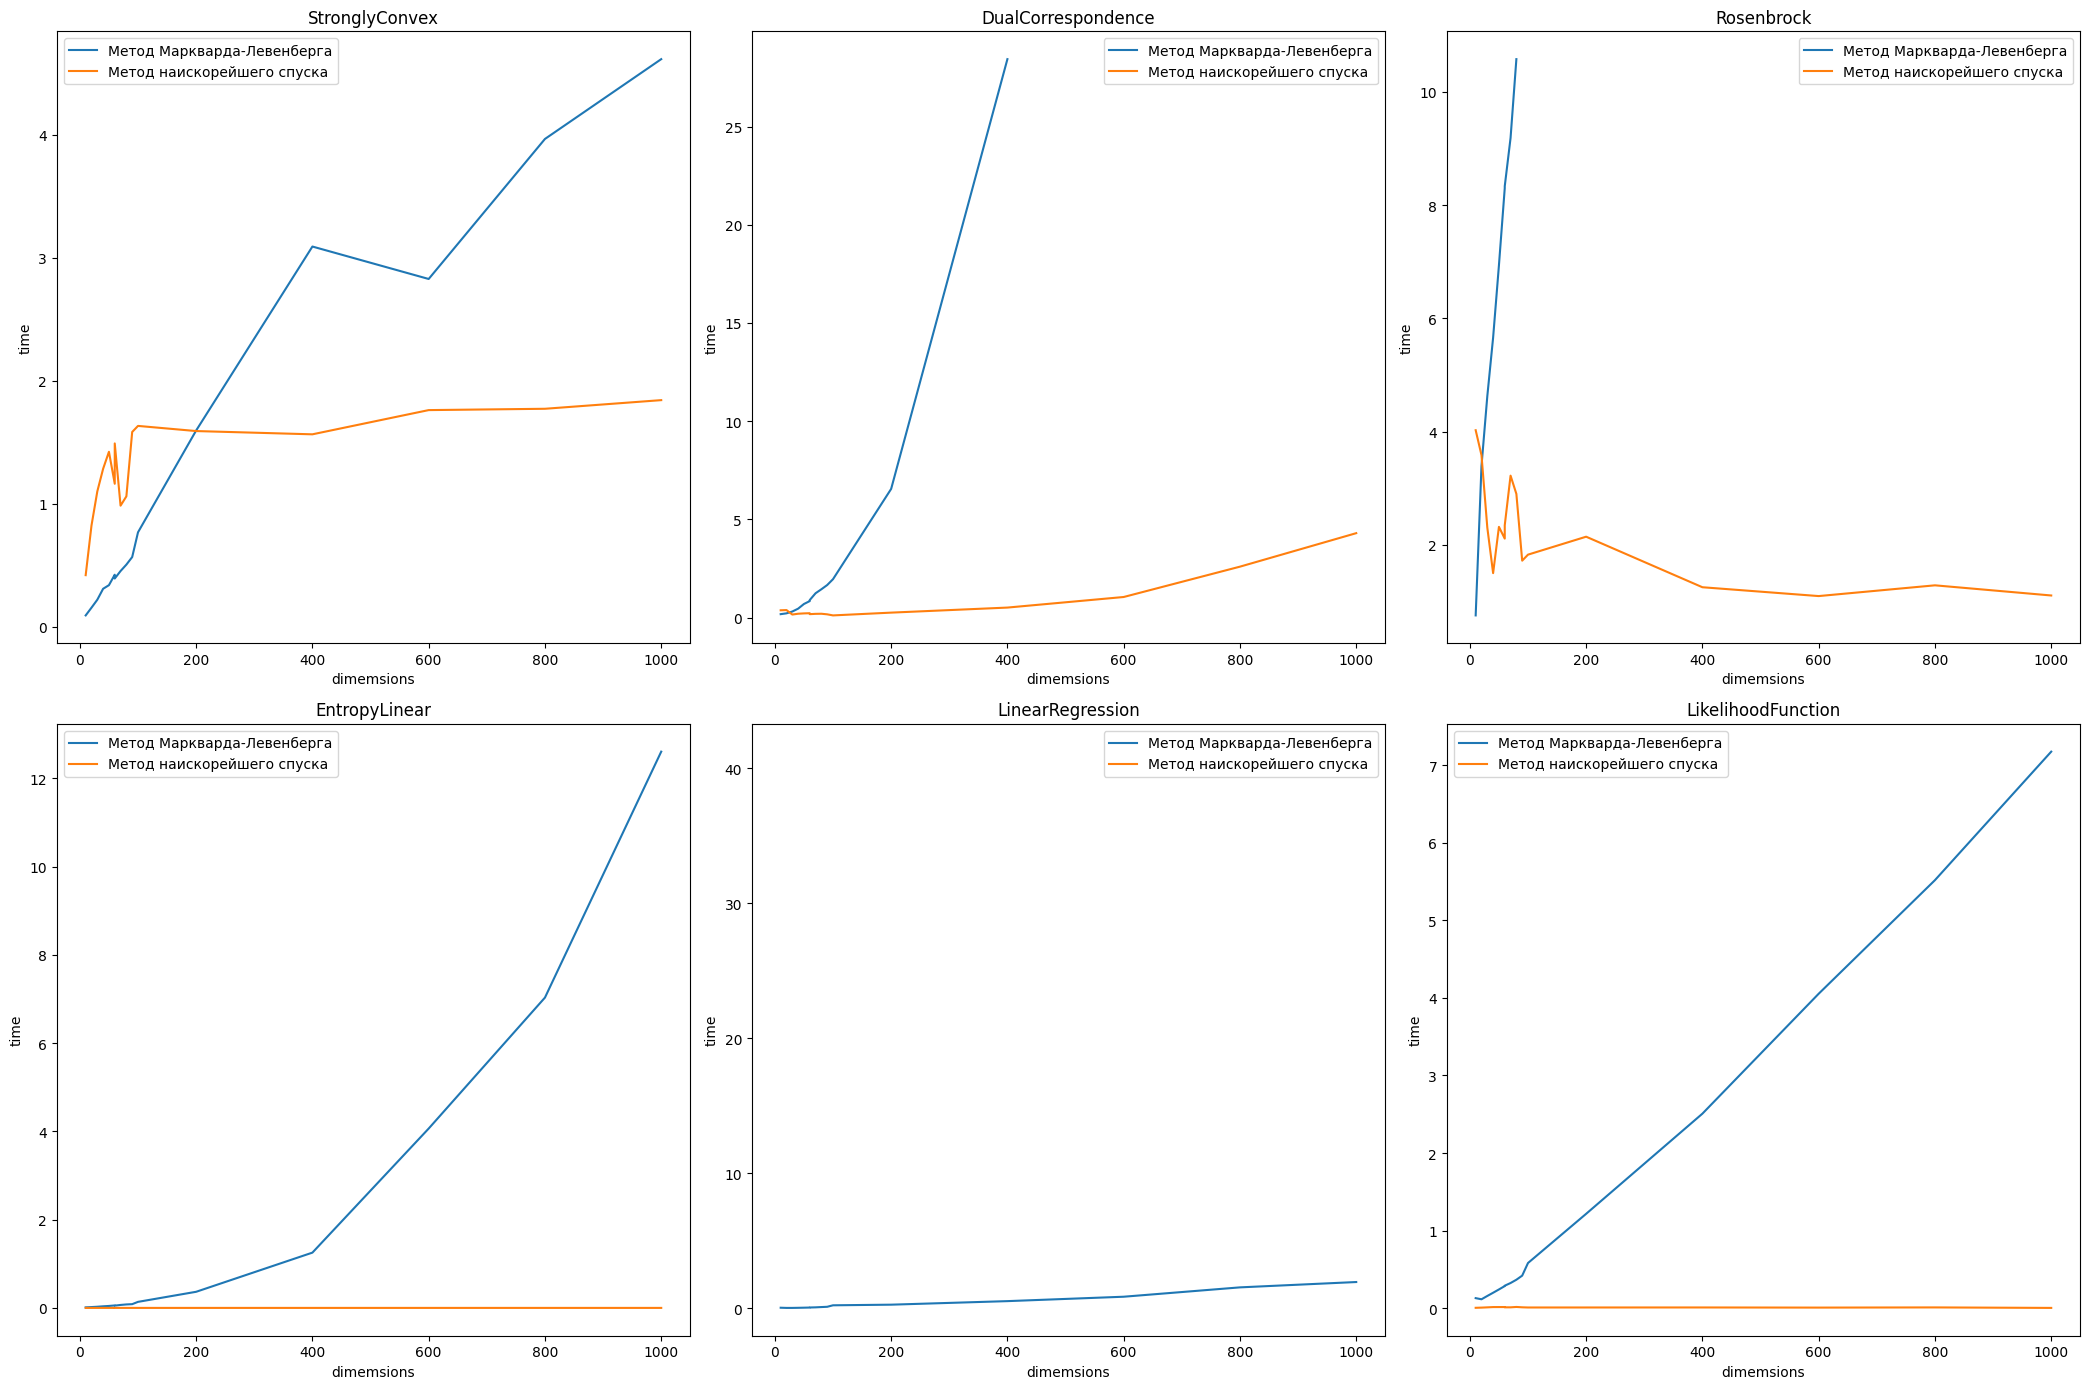

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(21, 14))  # figsize=(ширина, высота)
plt.tight_layout(pad=8.0)

prec = 1e-5
steps = 100000

Lst_y_lev = []
Lst_x_lev = []
Lst_y_fast = []
Lst_x_fast = []

for i in range(number_of_func):
    Lst_y_lev.append([])
    Lst_y_fast.append([])
    Lst_x_lev.append([])
    Lst_x_fast.append([])
    for dim in dimemsions:
        start_time = time.time()
        x0, param_list = param_gen[i](dim)
        max_steps, eps = steps, prec
        result = levenberg_markvatd2(function_list[i], param_list, x0, max_steps, eps)
        end_time = time.time()
        Lst_x_lev[i].append(dim)
        Lst_y_lev[i].append(end_time - start_time)
        if end_time - start_time > 10:
            break

for i in range(number_of_func):
    Lst_y_lev.append([])
    Lst_y_fast.append([])
    Lst_x_lev.append([])
    Lst_x_fast.append([])
    for dim in dimemsions:
        start_time = time.time()
        x0, param_list = param_gen[i](dim)
        max_steps, eps = steps, prec
        result = the_fastest_descent(function_list[i], param_list, x0, max_steps, eps)
        end_time = time.time()
        Lst_x_fast[i].append(dim)
        Lst_y_fast[i].append(end_time - start_time)
        if end_time - start_time > 10:
            break

for i in range(2):
    for j in range(3):
        ind = i * 3 + j
        axs[i, j].plot(Lst_x_lev[ind], Lst_y_lev[ind], label='Метод Маркварда-Левенберга')
        axs[i, j].plot(Lst_x_fast[ind], Lst_y_fast[ind], label='Метод наискорейшего спуска')
        axs[i, j].set_title(func_name_list[ind])
        axs[i, j].set_xlabel('dimemsions')
        axs[i, j].set_ylabel('time')
        axs[i, j].legend()

plt.tight_layout()
plt.show()

/home/asadbek/study/6sem/math_optimization/.venv/lib/python3.13/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
/home/asadbek/study/6sem/math_optimization/.venv/lib/python3.13/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/home/asadbek/study/6sem/math_optimization/.venv/lib/python3.13/site-packages/autograd/numpy/numpy_vjps.py:74: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp,    lambda ans, x : lambda g: ans * g)


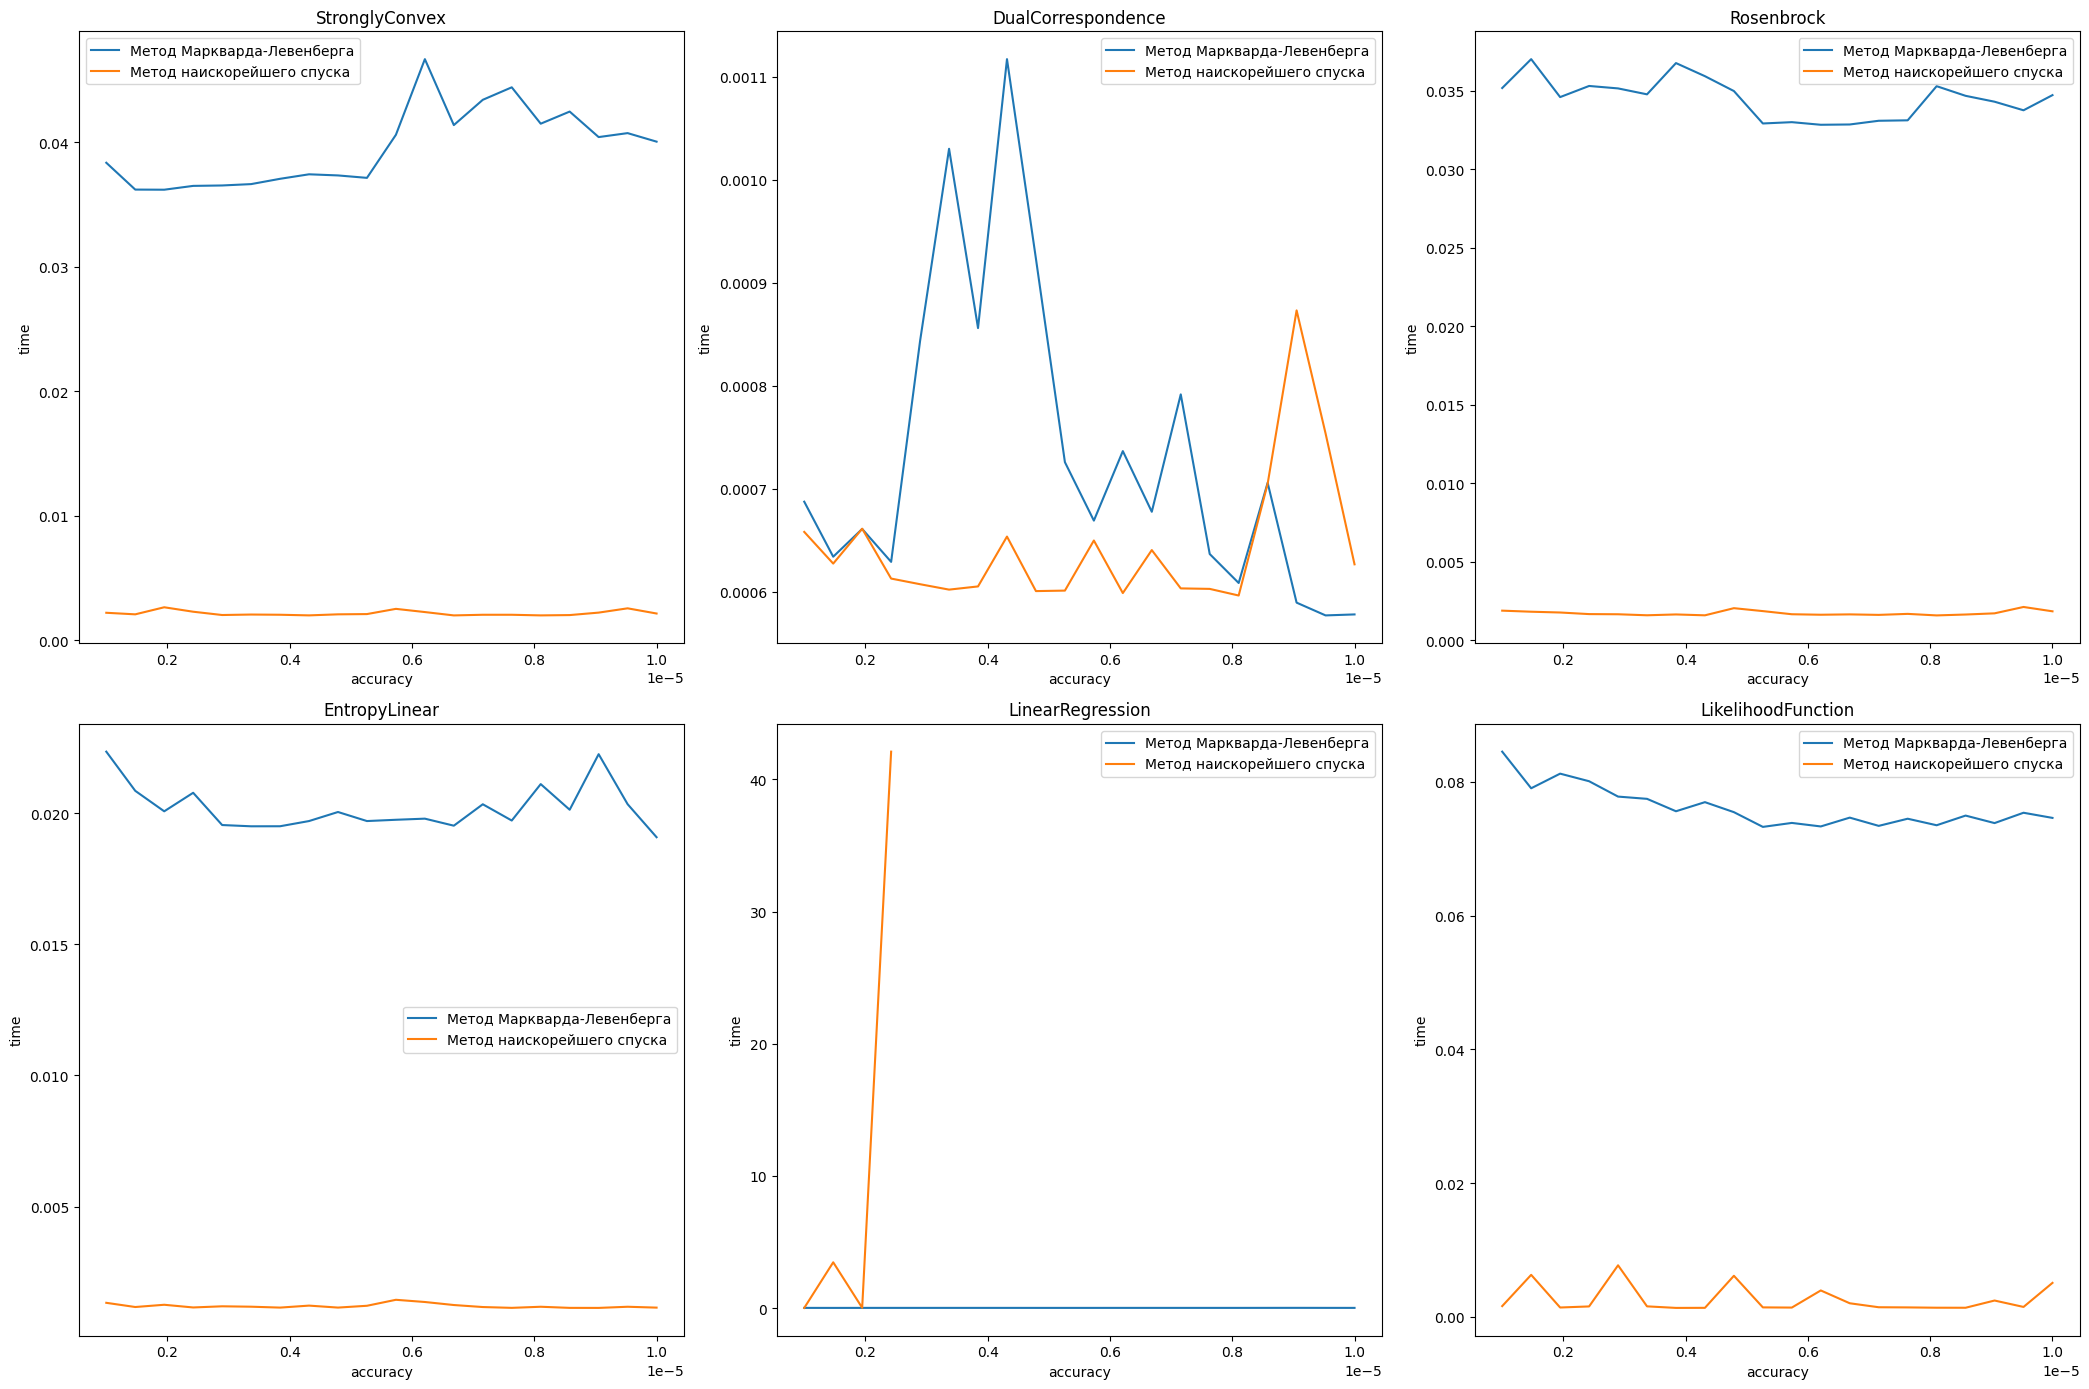

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(21, 14))  # figsize=(ширина, высота)
plt.tight_layout(pad=8.0)

dim = 1
steps = 100000
prec_list = np.linspace(10 ** (-6), 10 ** (-5), 20)

Lst_y_lev = []
Lst_x_lev = []
Lst_y_fast = []
Lst_x_fast = []

for i in range(number_of_func):
    Lst_y_lev.append([])
    Lst_y_fast.append([])
    Lst_x_lev.append([])
    Lst_x_fast.append([])
    for prec in prec_list:
        x0, param_list = param_gen[i](dim)
        max_steps, eps = steps, prec
        start_time = time.time()
        result = levenberg_markvatd2(function_list[i], param_list, x0, max_steps, eps)
        end_time = time.time()
        Lst_x_lev[i].append(prec)
        Lst_y_lev[i].append(end_time - start_time)
        if end_time - start_time > 10:
            break

for i in range(number_of_func):
    Lst_y_lev.append([])
    Lst_y_fast.append([])
    Lst_x_lev.append([])
    Lst_x_fast.append([])
    for prec in prec_list:
        x0, param_list = param_gen[i](dim)
        max_steps, eps = steps, prec
        start_time = time.time()
        result = the_fastest_descent(function_list[i], param_list, x0, max_steps, eps)
        end_time = time.time()
        Lst_x_fast[i].append(prec)
        Lst_y_fast[i].append(end_time - start_time)
        if end_time - start_time > 10:
            break


for i in range(2):
    for j in range(3):
        ind = i * 3 + j
        axs[i, j].plot(Lst_x_lev[ind], Lst_y_lev[ind], label='Метод Маркварда-Левенберга')
        axs[i, j].plot(Lst_x_fast[ind], Lst_y_fast[ind], label='Метод наискорейшего спуска')
        axs[i, j].set_title(func_name_list[ind])
        axs[i, j].set_xlabel('accuracy')
        axs[i, j].set_ylabel('time')
        axs[i, j].legend()


plt.tight_layout()
plt.show()

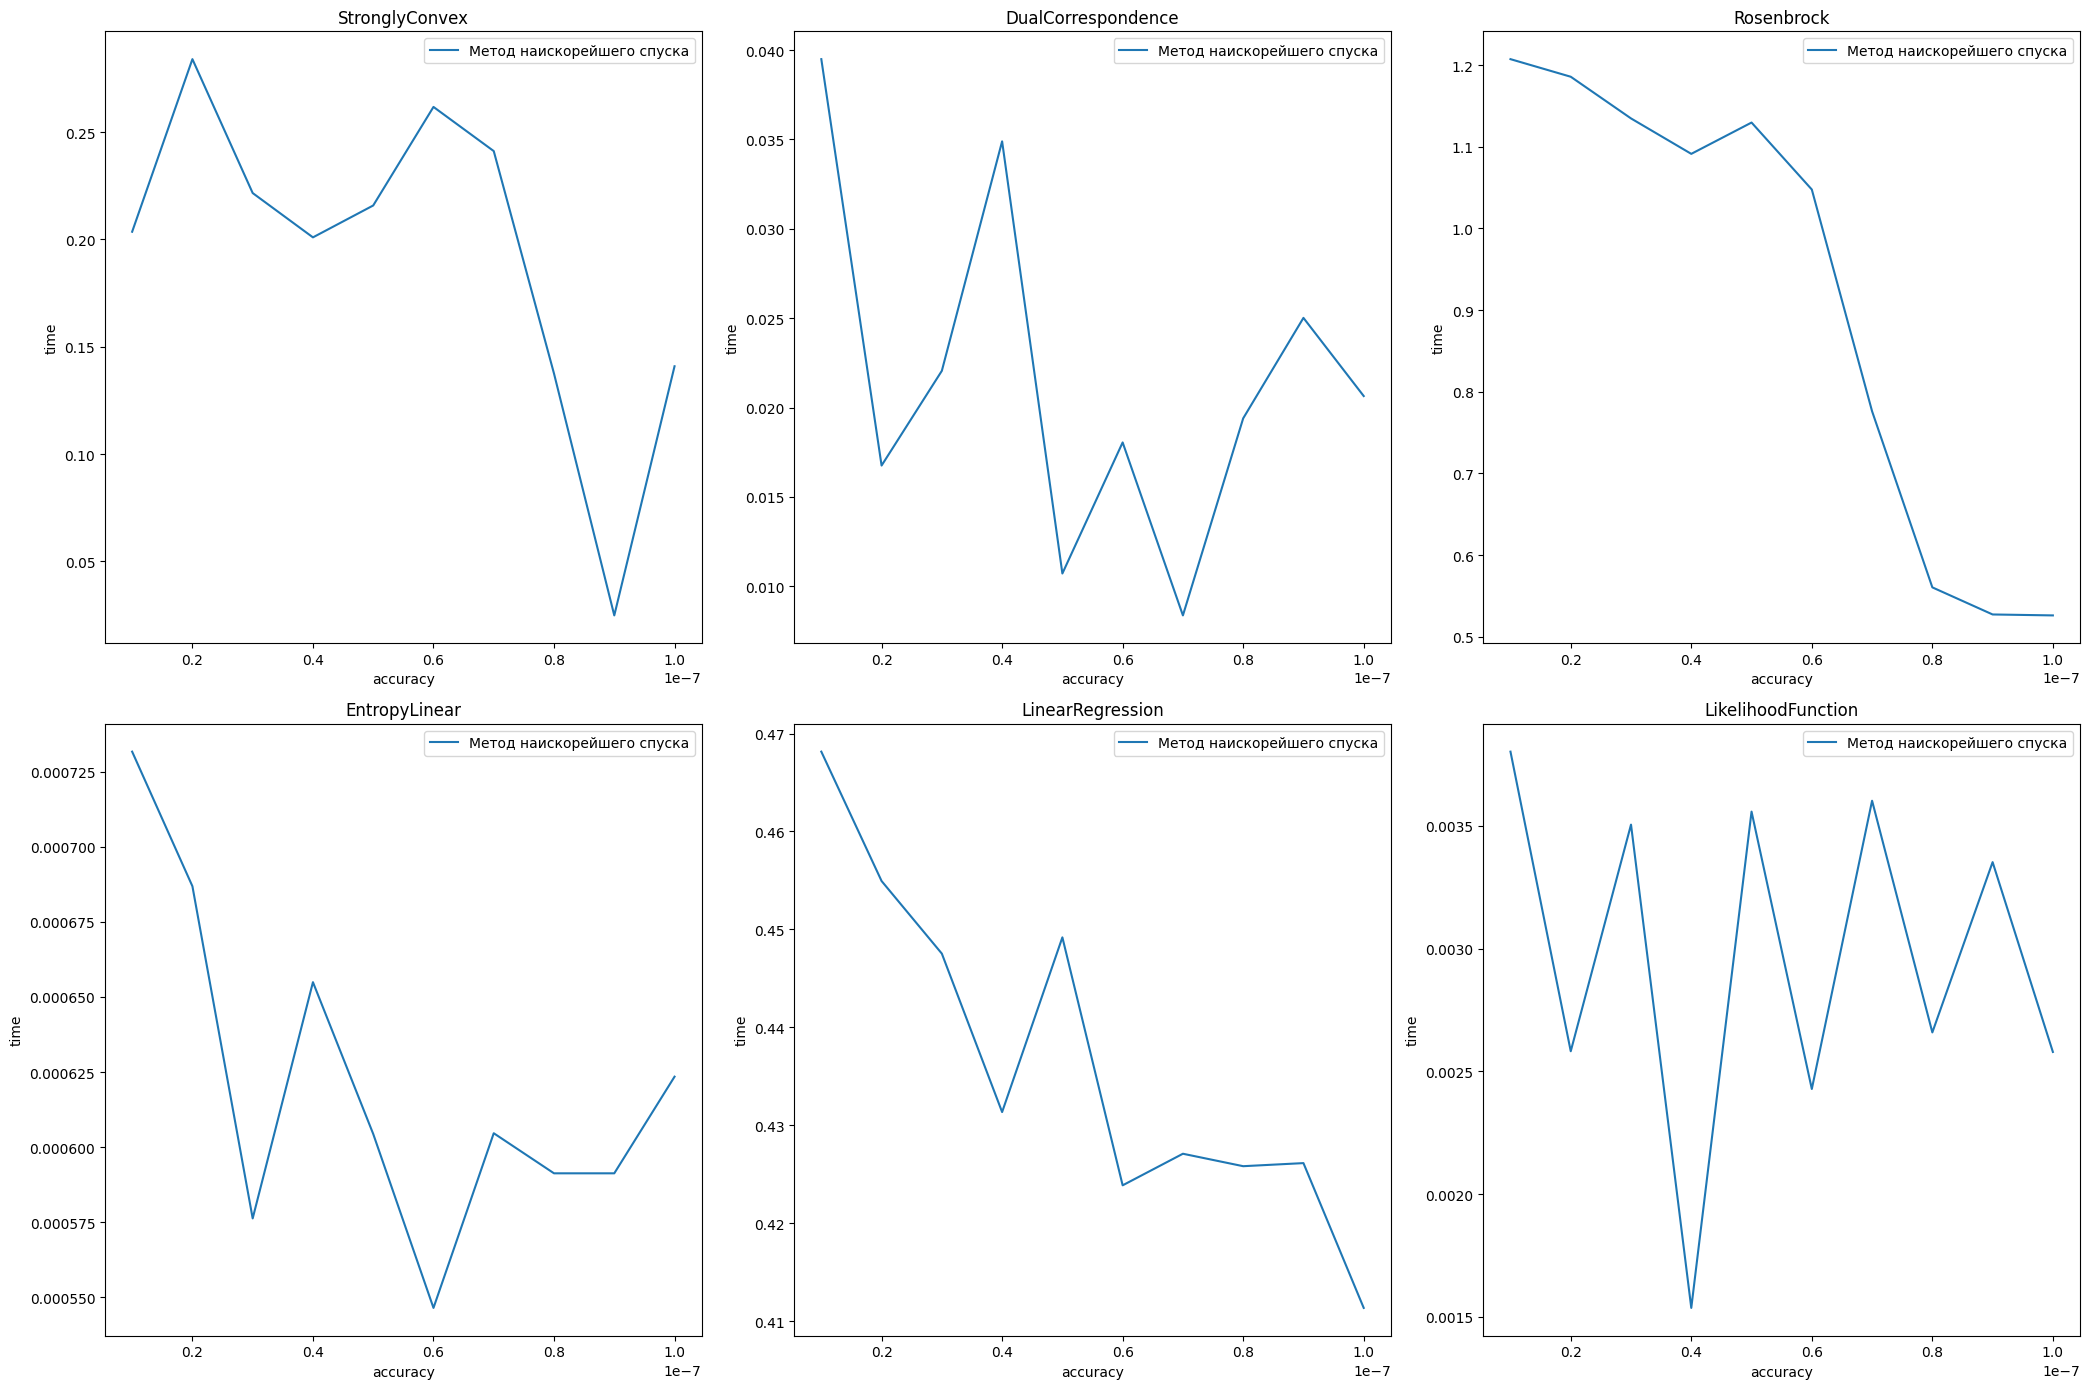

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(21, 14))  # figsize=(ширина, высота)
plt.tight_layout(pad=8.0)

prec = 1e-1
steps = 1000

Lst_y_lev = []
Lst_y_fast = []

for i in range(number_of_func):

    Lst_y_lev.append([])
    Lst_y_fast.append([])
    dim = 10
    for eps_golden in np.linspace(10 ** (-8), 10 ** (-7), 10):

        start_time = time.time()
        x0, param_list = param_gen[i](dim)
        max_steps, eps = steps, prec
        result = the_fastest_descent(function_list[i], param_list, x0, max_steps, eps)
        end_time = time.time()
        Lst_y_fast[i].append(end_time - start_time)


for i in range(2):
    for j in range(3):
        ind = i * 3 + j
        axs[i, j].plot(golden_section_accuracies, Lst_y_fast[ind], label='Метод наискорейшего спуска')
        axs[i, j].set_title(func_name_list[ind])
        axs[i, j].set_xlabel('accuracy')
        axs[i, j].set_ylabel('time')
        axs[i, j].legend()

plt.tight_layout()
plt.show()

/home/asadbek/study/6sem/math_optimization/.venv/lib/python3.13/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
/tmp/ipykernel_3537/3812578861.py:27: RuntimeWarning: overflow encountered in scalar power
  return (x[0] - 1) ** 2 + alpha_rosenbrock * agnp.sum((x[1:] - x[:-1] ** 2) ** 2)
/tmp/ipykernel_3537/3812578861.py:27: RuntimeWarning: overflow encountered in square
  return (x[0] - 1) ** 2 + alpha_rosenbrock * agnp.sum((x[1:] - x[:-1] ** 2) ** 2)
/home/asadbek/study/6sem/math_optimization/.venv/lib/python3.13/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)
/tmp/ipykernel_3537/2929843844.py:16: RuntimeWarning: invalid value encountered in multiply
  return f(x_old + h * d, param_list)
/tmp/ipykernel_3537/3812578861.py:27: RuntimeWarning: invalid value encountered in subtract
  return (x[0] - 1) ** 2 + alpha_rosenbrock * agnp.sum((x[1:] - x[:-1] ** 2

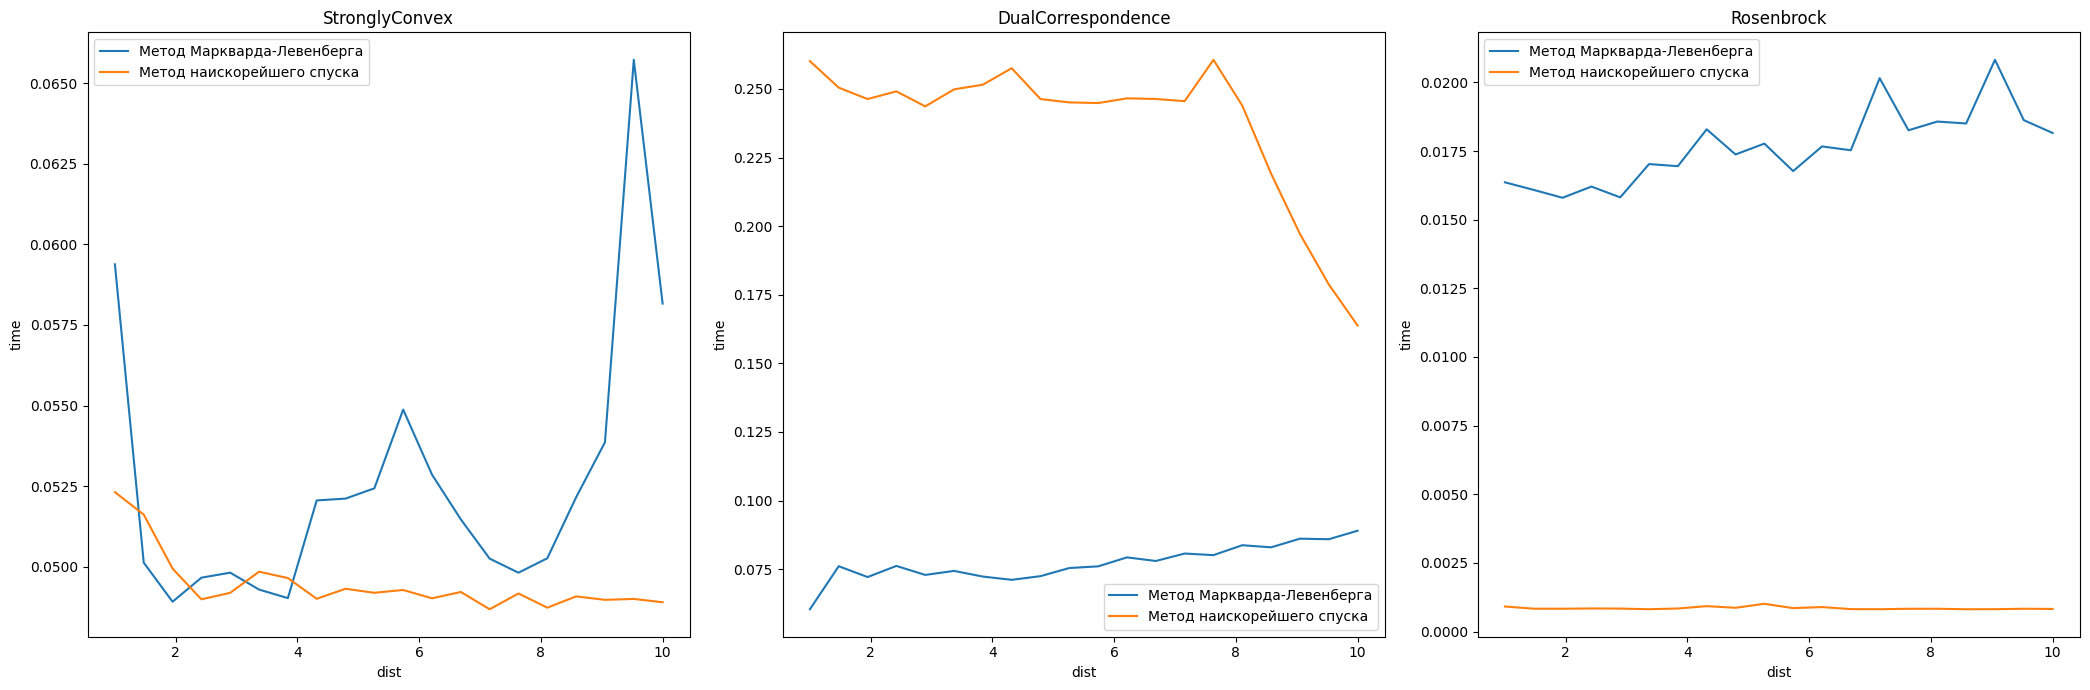

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))  # figsize=(ширина, высота)
plt.tight_layout(pad=8.0)

dim = 2
steps = 100000
prec = 1e-5
dist_list = np.linspace(10 ** (0), 10 ** (1), 20)

Lst_y_lev = []
Lst_x_lev = []
Lst_y_fast = []
Lst_x_fast = []

Lst_y_lev.append([])
Lst_x_lev.append([])
x_opt_list = [np.ones(dim), 0, np.ones(dim), (1 / np.arange(1, dim + 1)) * np.exp(-1), 0, 0]

j = 0
for i in [0, 2, 3]:
    Lst_y_lev.append([])
    Lst_x_lev.append([])

    for dist in dist_list:
        start_time = time.time()
        _, param_list = param_gen[i](dim)
        x0 = x_opt_list[i] + dist * np.ones(dim)
        max_steps, eps = steps, prec
        result = levenberg_markvatd2(function_list[i], param_list, x0, max_steps, eps)
        end_time = time.time()
        Lst_y_lev[j].append(end_time - start_time)
        if end_time - start_time > 10:
            break
    j += 1

j = 0
for i in [0, 2, 3]:
    Lst_y_fast.append([])
    Lst_x_fast.append([])
    for prec in prec_list:
        start_time = time.time()
        _, param_list = param_gen[i](dim)
        x0 = x_opt_list[i] + dist * np.ones(dim)
        start_time = time.time()
        result = the_fastest_descent(function_list[i], param_list, x0, max_steps, eps)
        end_time = time.time()
        Lst_y_fast[j].append(end_time - start_time)
        if end_time - start_time > 10:
            break
    j += 1


for j in range(3):
    axs[j].plot(dist_list, Lst_y_lev[j], label='Метод Маркварда-Левенберга')
    axs[j].plot(dist_list, Lst_y_fast[j], label='Метод наискорейшего спуска')
    axs[j].set_title(func_name_list[j])
    axs[j].set_xlabel('dist')
    axs[j].set_ylabel('time')
    axs[j].legend()


plt.tight_layout()
plt.show()